In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from regression_model import forecast_RULs, transformer, capacity_points, POLYNOMIAL_DEGREE
import regression_model
import sklearn.metrics
import scipy.stats as stats
import importlib
importlib.reload(regression_model)
from tqdm import tqdm

# Point forecasts

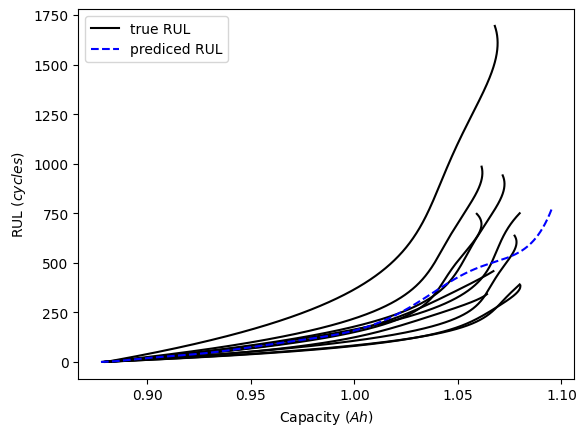

In [3]:
battery_test = pd.read_csv('../data/battery_test.csv')
battery_test_capacities = battery_test.drop(columns=['Cycle'])
battery_test_RULs = battery_test_capacities.copy()

for battery in battery_test_capacities:
    capacities = battery_test[battery].dropna()
    total_useful_life = len(capacities)
    # print(len(battery_test_capacities.index) - total_useful_life)
    # print(np.repeat(np.nan, len(battery_test_capacities.index) - total_useful_life))
    battery_test_RULs[battery] = np.append(np.arange(total_useful_life - 1, -1, -1), np.repeat(np.nan, len(battery_test_capacities.index) - total_useful_life))

for battery in battery_test_RULs:
    x = battery_test_capacities[battery].dropna()
    y = battery_test_RULs[battery].dropna()

    # I'm so sorry. I will fix this horrible code later
    if battery == 'NO.1':
        plt.plot(x, y, color='black', linestyle='solid', label='true RUL')
    else:
        plt.plot(x, y, color='black', linestyle='solid')

N = 200
x_linspace = np.linspace(np.min(regression_model.capacity_points), np.max(regression_model.capacity_points), N)
y_pred = regression_model.forecast_RULs(x_linspace)
plt.plot(x_linspace, y_pred, color='blue', linestyle='dashed', label='prediced RUL')
plt.xlabel('Capacity ($Ah$)')
plt.ylabel('RUL ($cycles$)')
plt.legend()
plt.show()

# Prediction performance

In [4]:
battery_data = pd.read_csv('../data/battery_test.csv')
capacity_points = np.array([])
RUL_points = np.array([])

# Extract (capacity, RUL) points (over all cycles) for every battery into (capacity_points, RUL_points)
for column in battery_data:
    if column == 'Cycle':
        continue

    capacities = battery_data[column].dropna()
    total_useful_life = len(capacities)
    RULs = np.arange(total_useful_life - 1, -1, -1) # The first measured capacity corresponds to an RUL of total_useful_life - 1 as the battery has already consumed a cycle of its life
    capacity_points = np.concatenate((capacity_points, capacities))
    RUL_points = np.concatenate((RUL_points, RULs))

true_RULs = RUL_points
predicted_RULs = regression_model.forecast_RULs(capacity_points)
n = len(true_RULs)
mean_squared_error = np.sum((true_RULs - predicted_RULs) ** 2) / n
print(f'{mean_squared_error=}')



# y_true = np.array([[]])
# y_pred = np.array([[]])

# for battery in battery_test_RULs:
#     RULs = battery_test[battery]
#     y_true = np.append(y_true, RULs.to_numpy().reshape((-1, 1)), axis=1)
    
# print(y_true)
# symmetric_mean_absolute_percentage_error = 1 / n * np.sum(np.abs((true_RULs - predicted_RULs) / true_RULs))
# print(f'{symmetric_mean_absolute_percentage_error=}')
symmetric_mean_absolute_percentage_error = 1 / n * np.sum(np.abs(true_RULs - predicted_RULs) / ((np.abs(true_RULs) + np.abs(predicted_RULs)) / 2))
print(f'{symmetric_mean_absolute_percentage_error=}')


# for battery in battery_test_RULs:
#     capacities = battery_test_capacities[battery].dropna()
#     y_true = battery_test_RULs[battery].dropna()
#     y_pred = regression_model.forecast_RULs(capacities)
#     mean_absolute_percentage_error = sklearn.metrics.mean_absolute_percentage_error(y_true, y_pred)
#     print(f'Mean absolute percentage error battery {battery}: {mean_absolute_percentage_error}')

mean_squared_error=108396.34206159528
symmetric_mean_absolute_percentage_error=0.4266732514584623


In [5]:
n = len(true_RULs)
EPSILON = 1e-10

def get_prediction_interval(x, y_pred, alpha=0.05):
    # std = np.sqrt(np.sum((true_RULs - predicted_RULs) ** 2) / (n - 2) * (1 + 1 / n + (x - np.mean(capacity_points) ** 2 / np.sum((capacity_points - np.mean(capacity_points)) ** 2))))
    # quantile = stats.norm.ppf(1 - alpha / 2)
    # interval = quantile * std
    p = regression_model.POLYNOMIAL_DEGREE
    se = np.sqrt(np.sum((true_RULs - np.mean(predicted_RULs)) ** 2) / (n - p))
    interval = stats.t(df=n-p).ppf(1 - alpha / 2) * se * np.sqrt(1 + 1 / n + (x - np.mean(capacity_points)) ** 2 / np.sum((capacity_points - np.mean(capacity_points)) ** 2))
    upper = y_pred + interval
    lower = y_pred - interval
    return lower, upper

def get_confidence_interval(x, y_pred, alpha=0.05):
    p = regression_model.POLYNOMIAL_DEGREE
    se = np.sqrt(np.sum((true_RULs - np.mean(predicted_RULs)) ** 2) / (n - p))
    interval = stats.t(df=n-p).ppf(1 - alpha / 2) * se * np.sqrt(1 / n + (x - np.mean(capacity_points)) ** 2 / np.sum((capacity_points - np.mean(capacity_points)) ** 2))
    upper = y_pred + interval
    lower = y_pred - interval
    return lower, upper

convered_RULs = 0

for capacity, true_RUL, predicted_RUL in zip(capacity_points, true_RULs, predicted_RULs):
    lower, upper = get_prediction_interval(capacity, predicted_RUL)
    is_in_interval = (lower - EPSILON) <= true_RUL <= (upper + EPSILON)
    convered_RULs += 1 if is_in_interval else 0

coverage_percentage = convered_RULs / n * 100
print(f'{coverage_percentage=}')

coverage_percentage=94.00544959128065


7340it [00:38, 188.92it/s]
7340it [00:27, 266.32it/s]


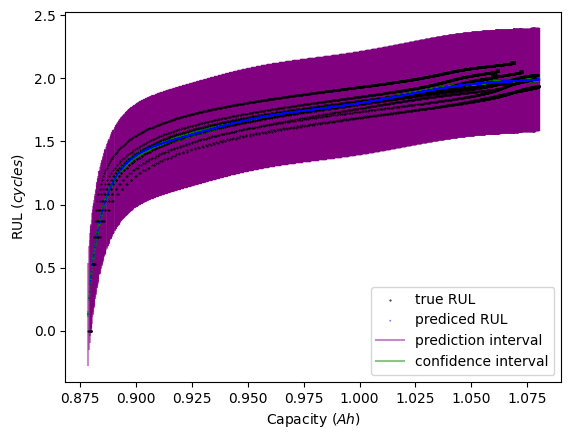

In [7]:
true_RULs = np.log(true_RULs + 1)
predicted_RULs = np.log(predicted_RULs + 1)

plt.scatter(capacity_points, true_RULs, color='black', s=0.2, label='true RUL')
plt.scatter(capacity_points, predicted_RULs, color='blue', linestyle='dashed', s=0.05, label='prediced RUL')

alpha = 0.45
for capacity, true_RUL, predicted_RUL in tqdm(zip(capacity_points, true_RULs, predicted_RULs)):
    color = 'purple'
    lower, upper = get_prediction_interval(capacity, predicted_RUL)

    # I'm sorry
    if capacity == capacity_points[0]:
        plt.plot([capacity] * 2, [lower, upper], color=color, alpha=alpha, zorder=-1, label='prediction interval')
    else:
        plt.plot([capacity] * 2, [lower, upper], color=color, alpha=alpha, zorder=-1)

for capacity, true_RUL, predicted_RUL in tqdm(zip(capacity_points, true_RULs, predicted_RULs)):
    color = 'green'
    lower, upper = get_confidence_interval(capacity, predicted_RUL)

    if capacity == capacity_points[0]:
        plt.plot([capacity] * 2, [lower, upper], color=color, alpha=alpha, zorder=-1, label='confidence interval')
    else:
        plt.plot([capacity] * 2, [lower, upper], color=color, alpha=alpha, zorder=-1)

plt.legend()
plt.xlabel('Capacity ($Ah$)')
plt.ylabel('RUL ($cycles$)')
plt.show()